<a href="https://colab.research.google.com/github/depinedo/clean_and_merge/blob/main/notebooks/01_simpson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survey Data with Pandas and StatsModels

Tutorial for PyCon 2025

Allen B. Downey

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurveyDataPandas/blob/main/notebooks/01_simpson.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Configure Matplotlib

plt.rcParams["figure.figsize"] = 7, 3.5
plt.rcParams["figure.dpi"] = 75
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False

In [3]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    legend = options.pop("legend", True)
    loc = options.pop("loc", "best")

    # Pass options to Axis.set
    ax = plt.gca()
    ax.set(**options)

    # Add a legend if there are any labeled elements
    handles, labels = ax.get_legend_handles_labels()
    if handles and legend:
        ax.legend(handles, labels, loc=loc)

    # Tight layout is generally a good idea
    plt.tight_layout()

## Data

We will use data from the [General Social Survey](https://gss.norc.org/) (GSS).
The raw dataset is big, so I've prepared an extract, which the following cell downloads.
The code to generate the extract is [in this notebook](https://github.com/AllenDowney/GssExtract/blob/main/notebooks/02_make_extract-2022_4.ipynb).

In [5]:
# This dataset is prepared in the GssExtract repository

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"

filename = "gss_extract_pacs_workshop.hdf"
download(DATA_PATH + filename)

Downloaded gss_extract_pacs_workshop.hdf


In [67]:
gss = pd.read_hdf(filename, key="gss")

In [18]:
gss.head()

,age,attend,ballot,class,cohort,degree,educ,fair,fear,goodlife,...,region,relig,rincome,satfin,satjob,sex,srcbelt,trust,wtssall,year
0,24.0,1.0,NaN,3.0,1948.0,3.0,16.0,2.0,NaN,NaN,...,1,1.0,NaN,1.0,NaN,1.0,5.0,1.0,1.3339,1972
1,33.0,2.0,NaN,2.0,1939.0,0.0,10.0,2.0,NaN,NaN,...,1,2.0,NaN,3.0,2.0,1.0,1.0,1.0,0.8893,1972
2,40.0,8.0,NaN,2.0,1932.0,1.0,12.0,2.0,NaN,NaN,...,1,5.0,NaN,1.0,NaN,2.0,3.0,2.0,1.3339,1972
3,24.0,2.0,NaN,2.0,1948.0,1.0,12.0,1.0,NaN,NaN,...,9,2.0,NaN,2.0,NaN,1.0,3.0,2.0,1.7786,1972
4,21.0,7.0,NaN,3.0,1951.0,1.0,12.0,1.0,NaN,NaN,...,9,1.0,NaN,1.0,NaN,2.0,2.0,NaN,1.7786,1972


In [19]:
gss.shape

(72390, 29)

In [20]:
gss.columns

Index(['age', 'attend', 'ballot', 'class', 'cohort', 'degree', 'educ', 'fair',
       'fear', 'goodlife', 'hapmar', 'happy', 'health', 'helpful', 'id',
       'life', 'partyid', 'polviews', 'race', 'region', 'relig', 'rincome',
       'satfin', 'satjob', 'sex', 'srcbelt', 'trust', 'wtssall', 'year'],
      dtype='object')

In [25]:
gss.isna().mean().sort_values() * 100

,0
id,0.000000
year,0.000000
wtssall,0.000000
region,0.000000
srcbelt,0.071833
race,0.179583
sex,0.208592
degree,0.294240
educ,0.433762
cohort,0.556707


## Distributions

We'll see two ways to describe distributions: value counts and KDE.

And for joint distributions, we'll use a cross tabulation.

In [6]:
def value_counts(seq, **options):
    """Make a series of values and the number of times they appear.

    Args:
        seq: sequence

    returns: Pandas Series
    """
    return pd.Series(seq).value_counts(**options).sort_index()

In [29]:
gss["year"].value_counts().sort_index()

,count
year,
1972,1613
1973,1504
1974,1484
1975,1490
1976,1499
1977,1530
1978,1532
1980,1468
1982,1860


<Axes: xlabel='year'>

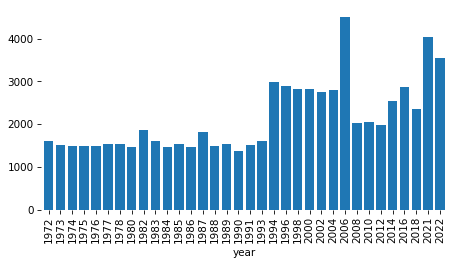

In [36]:
pmf = value_counts(gss["year"])
pmf.plot(kind="bar", width=0.8)

In [38]:
gss["age"].describe()

,age
count,71636.000000
mean,44.985943
std,17.201666
min,18.000000
25%,30.000000
50%,43.000000
75%,58.000000
max,89.000000


<Axes: xlabel='age', ylabel='Density'>

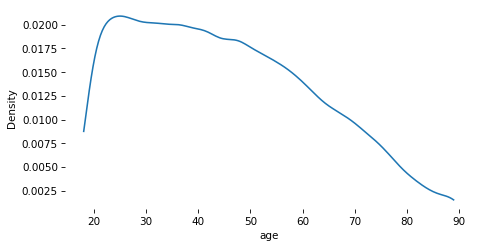

In [40]:
sns.kdeplot(gss["age"], cut = 0)

In [42]:
gss["cohort"].describe()

,cohort
count,71987.000000
mean,1991.908095
std,561.717010
min,1883.000000
25%,1938.000000
50%,1954.000000
75%,1968.000000
max,9999.000000


In [44]:
gss["cohort"] = gss["cohort"].replace(9999, np.nan)
gss['cohort'].describe()

,cohort
count,71635.000000
mean,1952.562853
std,21.977789
min,1883.000000
25%,1938.000000
50%,1954.000000
75%,1967.000000
max,2004.000000


### Exercise

Use `value_counts` to plot the distribution of `cohort` as a bar plot.
Then use `sns.kdeplot` to show the same distribution as a continuous quantity.

<BarContainer object of 122 artists>

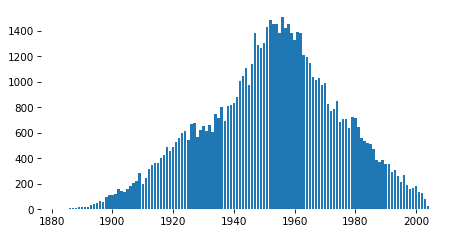

In [47]:
pmf = value_counts(gss['cohort'])
x = pmf.index
y = pmf.values
plt.bar(x, y)

<Axes: xlabel='cohort', ylabel='Density'>

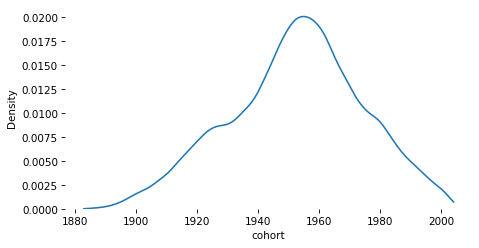

In [46]:
sns.kdeplot(gss["cohort"], cut = 0)

## Cross tabulation

Cross tabulation is a way to represent the joint distribution of two variables.

In [50]:
xtab = pd.crosstab(gss["cohort"], gss["age"])

<Axes: xlabel='age', ylabel='cohort'>

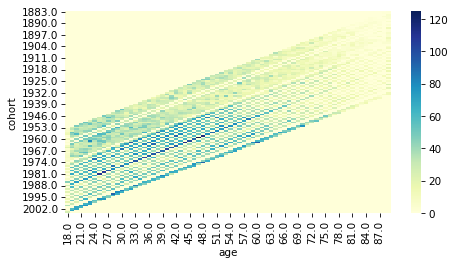

In [52]:
sns.heatmap(xtab, cmap = "YlGnBu")

## Target variable

I've selected four variables you might want to work with.
Whichever one you choose, put its cell last.

In [7]:
# https://gssdataexplorer.norc.org/variables/434/vshow

varname = 'happy'

question = """Taken all together, how would you say things are these days--
would you say that you are very happy, pretty happy, or not too happy?
"""

responses = ['Very happy', "Happy", 'Not too happy']

ylabel = "Percent saying 'very happy'"

In [8]:
# https://gssdataexplorer.norc.org/variables/439/vshow

varname = 'helpful'

question = """Would you say that most of the time people try to be helpful,
or that they are mostly just looking out for themselves?
"""

responses = ['Helpful', 'Look out\nfor themselves', 'Depends']

ylabel = "Percent saying 'helpful'"

In [10]:
# https://gssdataexplorer.norc.org/variables/441/vshow

varname = 'trust'

question = """Generally speaking, would you say that most people can be trusted
or that you can't be too careful in dealing with people?
"""

responses = ['Trusted', "Can't be\ntoo careful", 'Depends']

ylabel = "Percent saying 'trusted'"

In [68]:
# https://gssdataexplorer.norc.org/variables/440/vshow

varname = 'fair'

question = """Do you think most people would try to take advantage of you
if they got a chance, or would they try to be fair?
"""

# notice that the negative response is first here!
responses = ['Take advantage', 'Fair', 'Depends']

ylabel = "Percent saying 'fair'"

### Exercise

Do you think people who say "fair" are also more likely to say "helpful"?
To find out, make a cross tabulation of `trust` and `helpful`.
Consider using `normalize='index'`.
Make a heatmap that shows this joint distribution.
What relationships can you see in the responses?

In [60]:
fair_cross = pd.crosstab(gss['fair'], gss['helpful'], normalize = 'index') # normalize = "index" means to show the fraction of people in each row that selected each option
fair_cross

helpful,1.0,2.0,3.0
fair,,,
1.0,0.237323,0.711530,0.051147
2.0,0.670384,0.281203,0.048413
3.0,0.317647,0.326916,0.355437


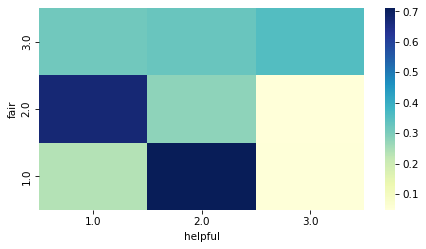

In [61]:
sns.heatmap(fair_cross, cmap = "YlGnBu")
plt.gca().invert_yaxis()

## Time Series

To see how responses have changed over time, we'll use cross tabulation again.

In [82]:
xtab = pd.crosstab(gss['year'], gss[varname], normalize="index")
xtab

fair,1.0,2.0,3.0
year,,,
1972,0.344828,0.605643,0.049530
1973,0.364793,0.591700,0.043507
1975,0.310719,0.622795,0.066486
1976,0.345430,0.620968,0.033602
1978,0.310481,0.633487,0.056032
1980,0.320716,0.636614,0.042670
1983,0.383648,0.562893,0.053459
1984,0.346075,0.621160,0.032765
1986,0.325069,0.635675,0.039256


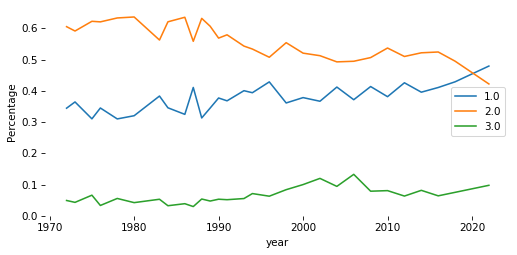

In [75]:
xtab.plot()
decorate(ylabel = "Percentage")

In [91]:
time_series = xtab[2] * 100
time_series

,2.0
year,
1972,60.564263
1973,59.170013
1975,62.279512
1976,62.096774
1978,63.348715
1980,63.661390
1983,56.289308
1984,62.116041
1986,63.567493


<Axes: xlabel='year'>

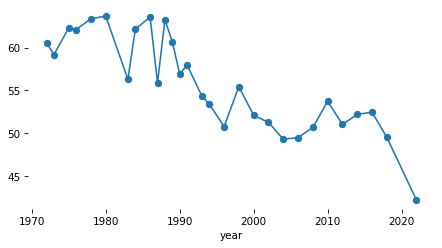

In [92]:
time_series.plot(style = "o-")

## Smoothing

To smooth the time series, we'll use LOWESS (locally weighted scatterplot smoothing).

In [89]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.to_numpy()
    x = series.index.to_numpy()

    smooth_array = lowess(y, x, frac)
    index, data = np.transpose(smooth_array)

    return pd.Series(data, index=index)

### Exercise

Use this function to make `smooth_series`.
Plot the result along with `time_series`.

In [94]:
smooth_series = make_lowess(time_series)

<Axes: xlabel='year'>

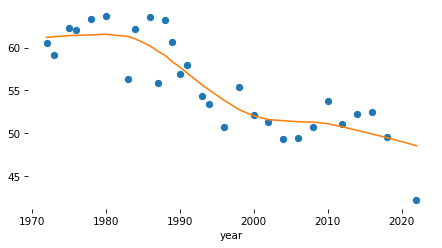

In [96]:
time_series.plot(style = "o")
smooth_series.plot()

## Binary series

It will be useful to convert the responses to a binary variable represented with 0s and 1s.

In [99]:
gss["y"] = (gss[varname] == 1) # True if response is 2 and False if the response is 1, 3
# We should not lump NaNs into nulls therefore this is wrongly states

In [137]:
gss["y"] = gss[varname].replace([1, 2, 3], [0, 1, 0])
gss["y"]

,y
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0
...,...
72385,1.0
72386,1.0
72387,NaN
72388,NaN


In [106]:
value_counts(gss["y"], dropna = False)

,count
y,
0.0,18816
1.0,23484
NaN,30090


In [107]:
gss["y"].mean()

np.float64(0.555177304964539)

In [108]:
value_counts(gss["y"])

,count
y,
0.0,18816
1.0,23484


## Pivot tables

Now we'll use a pivot table to put respondents in groups and see how the responses have changed over time.

In [109]:
polviews_map = {
    1: 'Liberal',
    2: 'Liberal',
    3: 'Liberal',
    4: 'Moderate',
    5: 'Conservative',
    6: 'Conservative',
    7: 'Conservative',
}

In [116]:
gss["polviews3"] = gss["polviews"].replace(polviews_map)
value_counts(gss["polviews3"], dropna = False)

,count
polviews3,
Conservative,21580
Liberal,17370
Moderate,23912
NaN,9528


In [118]:
table = gss.pivot_table(index = "year", columns = "polviews3", values = "y", aggfunc = "mean")

<Axes: xlabel='year'>

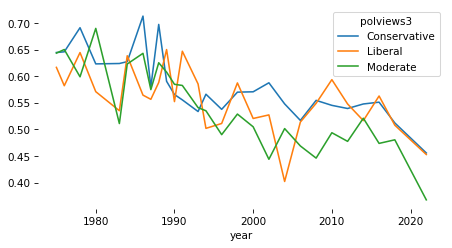

In [119]:
table.plot()

## Better colors

We'll select colors from a Seaborn color palette.

In [123]:
muted = sns.color_palette("muted")
muted

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [126]:
color_map = {
    'Liberal': muted[0],
    'Moderate': muted[2],
    'Conservative': muted[3],
}

### Exercise

Loop through the groups in `color_map`.
For each one, extract a column from `table` and plot the data points; then plot a smooth line.

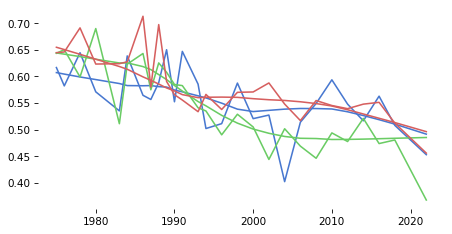

In [128]:
# Ai Solution
for i in color_map:
    plt.plot(table.index, table[i], label = i, color = color_map[i])

    smooth_series = make_lowess(table[i])
    plt.plot(table.index, smooth_series, color = color_map[i])

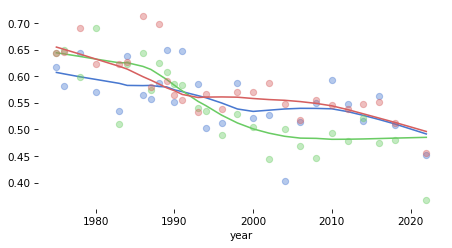

In [129]:
for group in color_map:
  color = color_map[group]
  series = table[group]
  series.plot(style = "o", color = color, alpha = 0.4)
  smooth = make_lowess(series)
  smooth.plot(color = color)

## Groupby

Now that we have `y` as a binary variable, we have another way to compute the time series and the pivot table.
There are pros and cons of each method.

## Logistic regression

We'll use logistic regression to model changes over time.

In [146]:
year_shift = gss["year"].median()
gss["x"] = gss["year"] - year_shift

In [147]:
subset = gss.dropna(subset=['y', 'x'])
subset.shape

(42300, 32)

In [148]:
import statsmodels.formula.api as smf

formula = 'y ~ x + I(x**2)'
model = smf.logit(formula, data=subset).fit()
# model.summary()
model.params # shorter version

Optimization terminated successfully.
         Current function value: 0.682751
         Iterations 4


,0
Intercept,0.180868
x,-0.012867
I(x ** 2),0.000014


In [152]:
year_range = np.arange(1972, 2026)
pred_df = pd.DataFrame({"x" : year_range - year_shift})
pred_series = model.predict(pred_df)
pred_series.index = year_range
pred_series

,0
1972,0.628326
1973,0.625146
1974,0.621962
1975,0.618774
1976,0.615582
1977,0.612387
1978,0.609189
1979,0.605989
1980,0.602786
1981,0.599582


In [154]:
year_range = np.arange(1972, 2026)
pred_df = pd.DataFrame({"x" : year_range - year_shift})
pred_series = model.predict(pred_df) * 100
pred_series.index = year_range
pred_series

,0
1972,62.832619
1973,62.514603
1974,62.196175
1975,61.877364
1976,61.558201
1977,61.238718
1978,60.918943
1979,60.598910
1980,60.278647
1981,59.958186


<Axes: xlabel='year'>

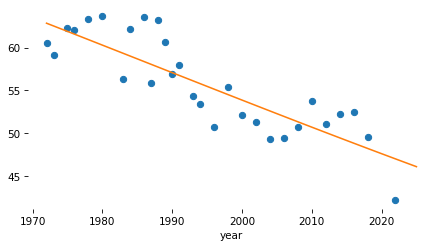

In [155]:
time_series.plot(style = "o")
pred_series.plot()

In [ ]:
# Remember Logit cannot address NaNs
def fit_model(data, x_range, x_shift):
    formula = 'y ~ x + I(x**2)'
    model = smf.logit(formula, data=data).fit(disp=False)

    pred_df = pd.DataFrame(dict(x=x_range - x_shift))
    pred = model.predict(pred_df) * 100
    pred.index = x_range
    pred.name = 'model'

    return pred

### Exercise

Use `subset.groupby('polviews3')` to loop through the groups.
For each one, use `fit_model` to generate and plot a "prediction" for the group.

Conservative 12949
Liberal 9852
Moderate 14010


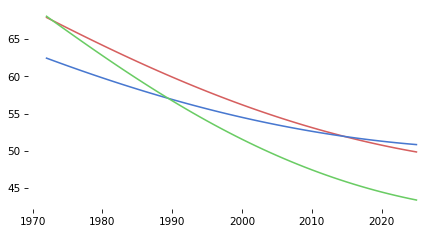

In [160]:
for name, group in subset.groupby('polviews3'):
    print(name, len(group))
    color = color_map[name]
    pred_series = fit_model(group, year_range, year_shift)
    pred_series.plot(color = color)

## Group by cohort

Now let's group respondents by decade of birth and see how each cohort changes over time.


In [161]:
def round_into_bins(series, bin_width, low=0, high=None):
    """Rounds values down to the bin they belong in.

    series: pd.Series
    bin_width: number, width of the bins

    returns: Series of bin values (with NaN preserved)
    """
    if high is None:
        high = series.max()

    bins = np.arange(low, high + bin_width, bin_width)
    indices = np.digitize(series, bins)
    result = pd.Series(bins[indices - 1], index=series.index, dtype='float')

    result[series.isna()] = np.nan
    return result

In [162]:
gss["cohort10"] = round_into_bins(gss["cohort"], 10, 1880)
value_counts(gss["cohort10"])

,count
cohort10,
1880.0,45
1890.0,501
1900.0,1722
1910.0,3616
1920.0,5862
1930.0,7115
1940.0,10925
1950.0,14273
1960.0,11699


## All the Cohorts

Now let's compare cohorts. The following function encapsulates the steps from the previous section.

In [164]:
gss.query("cohort10 == 1960")

,age,attend,ballot,class,cohort,degree,educ,fair,fear,goodlife,...,satjob,sex,srcbelt,trust,wtssall,year,y,polviews3,x,cohort10
9448,18.0,6.0,NaN,3.0,1960.0,0.0,10.0,1.0,NaN,NaN,...,3.0,2.0,6.0,2.0,1.012700,1978,0.0,NaN,-20.0,1960.0
9619,18.0,6.0,NaN,3.0,1960.0,0.0,10.0,1.0,NaN,NaN,...,3.0,2.0,6.0,2.0,1.012700,1978,0.0,NaN,-20.0,1960.0
9719,18.0,2.0,NaN,2.0,1960.0,0.0,11.0,2.0,NaN,NaN,...,NaN,2.0,5.0,3.0,1.012700,1978,1.0,Liberal,-20.0,1960.0
9776,18.0,2.0,NaN,3.0,1960.0,1.0,11.0,1.0,NaN,NaN,...,NaN,2.0,1.0,2.0,1.012700,1978,0.0,Liberal,-20.0,1960.0
10102,18.0,1.0,NaN,2.0,1960.0,0.0,11.0,2.0,NaN,NaN,...,NaN,2.0,6.0,1.0,1.012700,1978,1.0,Liberal,-20.0,1960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72361,61.0,0.0,3.0,3.0,1961.0,1.0,12.0,2.0,NaN,4.0,...,1.0,1.0,3.0,1.0,5.637197,2022,1.0,Conservative,24.0,1960.0
72363,61.0,1.0,1.0,3.0,1961.0,4.0,20.0,NaN,2.0,NaN,...,NaN,1.0,1.0,NaN,2.355126,2022,NaN,Moderate,24.0,1960.0
72367,54.0,3.0,2.0,2.0,1968.0,3.0,16.0,NaN,NaN,5.0,...,2.0,1.0,5.0,NaN,6.472268,2022,NaN,Conservative,24.0,1960.0
72368,56.0,0.0,1.0,2.0,1966.0,3.0,20.0,NaN,2.0,NaN,...,2.0,1.0,3.0,NaN,2.955249,2022,NaN,Conservative,24.0,1960.0


In [163]:
def plot_cohort(df, cohort, color='C0'):
    cohort_df = df.query("cohort10 == @cohort").dropna(subset=['y', 'x'])

    cohort_series = cohort_df.groupby('year')['y'].mean() * 100

    year_range = cohort_series.index

    pred_series = fit_model(cohort_df, year_range, year_shift)
    x, y = pred_series.index[-1], pred_series.values[-1]
    plt.text(x, y, cohort, ha='left', va='center')

    pred_series.plot(label=cohort, color=color)

In [168]:
pred_all = fit_model(subset, year_range, year_shift)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


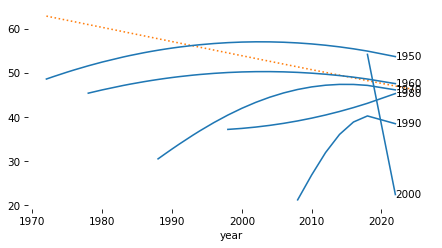

In [171]:
pred_all.plot(style =":", color = "C1")

plot_cohort(gss, 1950)
plot_cohort(gss, 1960)
plot_cohort(gss, 1970)
plot_cohort(gss, 1980)
plot_cohort(gss, 1990)
plot_cohort(gss, 2000)

### Exercise

Plot `pred_all`.
Then loop through `cohorts` and `colors`, and call `plot_cohort` for each group.

Depending on which target variable you chose, you might get a warning from StatsModels.

## Simpson's Paradox

The composition of the population changes over time.


## Sampling weights

The GSS uses stratified sampling, so some respondents represent more people in the population than others.
We can use resampling to correct for stratified sampling.

In [16]:
def resample_by_year(df, column='wtssall'):
    """Resample rows within each year using weighted sampling.

    df: DataFrame
    column: string name of weight variable

    returns: DataFrame
    """
    grouped = df.groupby('year')
    samples = [group.sample(n=len(group), replace=True, weights=group[column])
               for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample


Copyright 2025 Allen Downey

The code in this notebook is under the [MIT license](https://mit-license.org/).